In [1]:
from compute_epv import *
from xgboost import plot_importance
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [19]:
X = pd.read_parquet('X_epv.parquet')
Y = pd.read_parquet('Y_epv.parquet')
Y_pred = pd.DataFrame()

X_train, X_test, y_train, y_test = train_test_split(X.values, Y['concedes'].values, test_size=0.2, stratify=Y['concedes'].values, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [20]:
brier_score_loss(y_test, [0] * len(y_test))

0.001744333097848365

In [9]:
model_concedes = XGBClassifier(obj=brier_obj_sklearn, verbosity=1, disable_default_eval_metric=1)
model_concedes.fit(X_train, y_train,
                 eval_metric=brier_score_sklearn,
                 eval_set=[(X_train, y_train), (X_test, y_test)],
                 verbose=True)

[0]	validation_0-brier-error:0.12635	validation_1-brier-error:0.12637
[1]	validation_0-brier-error:0.06691	validation_1-brier-error:0.06694
[2]	validation_0-brier-error:0.03640	validation_1-brier-error:0.03644
[3]	validation_0-brier-error:0.02031	validation_1-brier-error:0.02037
[4]	validation_0-brier-error:0.01171	validation_1-brier-error:0.01178
[5]	validation_0-brier-error:0.00707	validation_1-brier-error:0.00715
[6]	validation_0-brier-error:0.00456	validation_1-brier-error:0.00464
[7]	validation_0-brier-error:0.00318	validation_1-brier-error:0.00328
[8]	validation_0-brier-error:0.00243	validation_1-brier-error:0.00253
[9]	validation_0-brier-error:0.00202	validation_1-brier-error:0.00213
[10]	validation_0-brier-error:0.00180	validation_1-brier-error:0.00191
[11]	validation_0-brier-error:0.00167	validation_1-brier-error:0.00179
[12]	validation_0-brier-error:0.00160	validation_1-brier-error:0.00173
[13]	validation_0-brier-error:0.00155	validation_1-brier-error:0.00169
[14]	validation_

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              disable_default_eval_metric=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              obj=<function brier_obj_sklearn at 0x0000020C95949280>,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=1)

<ipython-input-11-594fe0bcb82b>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


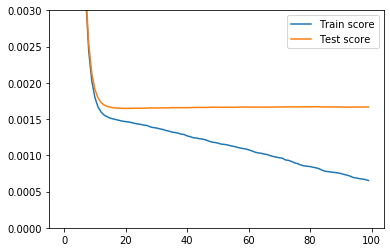

In [11]:
results = model_concedes.evals_result()
epochs = len(results['validation_0']['brier-error'])
fig, ax = plt.subplots()
ax.plot(range(0, epochs), results['validation_0']['brier-error'], label='Train score')
ax.plot(range(0, epochs), results['validation_1']['brier-error'], label='Test score')
ax.set_ylim(0, 0.003)
ax.legend()
fig.show()

In [12]:
Y_pred['concedes'] = model_concedes.predict_proba(X_test)[:, 1]
print(f"  Brier score: %.6f" % brier_score_loss(y_test, Y_pred['concedes']))
print(f"  ROC AUC: %.4f" % roc_auc_score(y_test, Y_pred['concedes']))

  Brier score: 0.001667
  ROC AUC: 0.8368


In [14]:
model_concedes1 = XGBClassifier(learning_rate=0.1, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8,
                             colsample_bytree=0.8, scale_pos_weight=1, verbosity=1, seed=42)
params1 = dict(n_estimators=range(50, 300, 50))
grid_search1 = GridSearchCV(model_concedes1, params1, scoring='brier_score_loss', n_jobs=1, cv=cv, verbose=10,
                            return_train_score=True)
gs_results1 = grid_search1.fit(X_train, y_train)
gs_results1.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=50, score=(train=-0.002, test=-0.002), total= 1.7min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV] n_estimators=50 .................................................
[CV]  n_estimators=50, score=(train=-0.002, test=-0.002), total= 1.8min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.6min remaining:    0.0s


[CV] n_estimators=50 .................................................
[CV]  n_estimators=50, score=(train=-0.002, test=-0.002), total= 1.8min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.5min remaining:    0.0s


[CV] n_estimators=50 .................................................
[CV]  n_estimators=50, score=(train=-0.002, test=-0.002), total= 1.8min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.4min remaining:    0.0s


[CV] n_estimators=50 .................................................
[CV]  n_estimators=50, score=(train=-0.002, test=-0.002), total= 1.8min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.2min remaining:    0.0s


[CV] n_estimators=100 ................................................
[CV]  n_estimators=100, score=(train=-0.001, test=-0.002), total= 3.6min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 12.9min remaining:    0.0s


[CV] n_estimators=100 ................................................
[CV]  n_estimators=100, score=(train=-0.001, test=-0.002), total= 3.6min


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 16.5min remaining:    0.0s


[CV] n_estimators=100 ................................................
[CV]  n_estimators=100, score=(train=-0.001, test=-0.002), total= 3.6min


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 20.2min remaining:    0.0s


[CV] n_estimators=100 ................................................
[CV]  n_estimators=100, score=(train=-0.001, test=-0.002), total= 3.6min


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 23.9min remaining:    0.0s


[CV] n_estimators=100 ................................................
[CV]  n_estimators=100, score=(train=-0.001, test=-0.002), total= 3.6min
[CV] n_estimators=150 ................................................
[CV]  n_estimators=150, score=(train=-0.001, test=-0.002), total= 5.5min
[CV] n_estimators=150 ................................................
[CV]  n_estimators=150, score=(train=-0.001, test=-0.002), total= 5.4min
[CV] n_estimators=150 ................................................
[CV]  n_estimators=150, score=(train=-0.001, test=-0.002), total= 5.5min
[CV] n_estimators=150 ................................................
[CV]  n_estimators=150, score=(train=-0.001, test=-0.002), total= 5.5min
[CV] n_estimators=150 ................................................
[CV]  n_estimators=150, score=(train=-0.001, test=-0.002), total= 5.4min
[CV] n_estimators=200 ................................................
[CV]  n_estimators=200, score=(train=-0.001, test=-0.002), total=

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 136.4min finished


{'n_estimators': 100}

In [15]:
gs_results1.best_params_

{'n_estimators': 100}

In [16]:
model_concedes2 = XGBClassifier(learning_rate=0.1, n_estimators=100, gamma=0, subsample=0.8,
                              colsample_bytree=0.8, scale_pos_weight=1, verbosity=1, seed=42)
params2 = dict(max_depth=range(3, 8, 2), min_child_weight=range(1, 6, 2))
grid_search2 = GridSearchCV(model_concedes2, params2, scoring='brier_score_loss', n_jobs=1, cv=cv, verbose=10,
                            return_train_score=True)
gs_results2 = grid_search2.fit(X_train, y_train)
gs_results2.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=3, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=3, min_child_weight=1, score=(train=-0.002, test=-0.002), total= 2.5min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s


[CV] max_depth=3, min_child_weight=1 .................................
[CV]  max_depth=3, min_child_weight=1, score=(train=-0.002, test=-0.002), total= 2.5min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.1min remaining:    0.0s


[CV] max_depth=3, min_child_weight=1 .................................
[CV]  max_depth=3, min_child_weight=1, score=(train=-0.002, test=-0.002), total= 2.5min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.7min remaining:    0.0s


[CV] max_depth=3, min_child_weight=1 .................................
[CV]  max_depth=3, min_child_weight=1, score=(train=-0.002, test=-0.002), total= 2.5min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 10.2min remaining:    0.0s


[CV] max_depth=3, min_child_weight=1 .................................
[CV]  max_depth=3, min_child_weight=1, score=(train=-0.002, test=-0.002), total= 2.5min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.8min remaining:    0.0s


[CV] max_depth=3, min_child_weight=3 .................................
[CV]  max_depth=3, min_child_weight=3, score=(train=-0.002, test=-0.002), total= 2.5min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 15.3min remaining:    0.0s


[CV] max_depth=3, min_child_weight=3 .................................
[CV]  max_depth=3, min_child_weight=3, score=(train=-0.002, test=-0.002), total= 2.5min


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 17.9min remaining:    0.0s


[CV] max_depth=3, min_child_weight=3 .................................
[CV]  max_depth=3, min_child_weight=3, score=(train=-0.002, test=-0.002), total= 2.5min


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 20.4min remaining:    0.0s


[CV] max_depth=3, min_child_weight=3 .................................
[CV]  max_depth=3, min_child_weight=3, score=(train=-0.002, test=-0.002), total= 2.5min


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 23.0min remaining:    0.0s


[CV] max_depth=3, min_child_weight=3 .................................
[CV]  max_depth=3, min_child_weight=3, score=(train=-0.002, test=-0.002), total= 2.4min
[CV] max_depth=3, min_child_weight=5 .................................
[CV]  max_depth=3, min_child_weight=5, score=(train=-0.002, test=-0.002), total= 2.5min
[CV] max_depth=3, min_child_weight=5 .................................
[CV]  max_depth=3, min_child_weight=5, score=(train=-0.002, test=-0.002), total= 2.5min
[CV] max_depth=3, min_child_weight=5 .................................
[CV]  max_depth=3, min_child_weight=5, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] max_depth=3, min_child_weight=5 .................................
[CV]  max_depth=3, min_child_weight=5, score=(train=-0.002, test=-0.002), total= 1.8min
[CV] max_depth=3, min_child_weight=5 .................................
[CV]  max_depth=3, min_child_weight=5, score=(train=-0.002, test=-0.002), total= 1.7min
[CV] max_depth=5, min_child_weight=1 .........

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 114.7min finished


{'max_depth': 5, 'min_child_weight': 5}

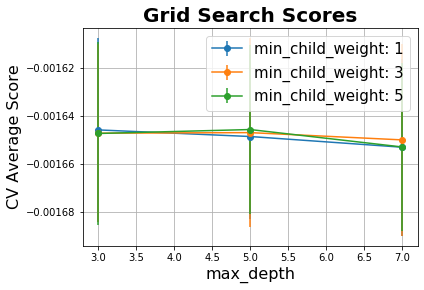

In [17]:
fig, ax = plot_grid_search(gs_results2.cv_results_)

In [18]:
model_concedes3 = XGBClassifier(learning_rate=0.1, n_estimators=100, gamma=0, subsample=0.8,
                                colsample_bytree=0.8, scale_pos_weight=1, verbosity=1, seed=42)
params3 = dict(max_depth=[4, 5, 6], min_child_weight=[4, 5, 6])
grid_search3 = GridSearchCV(model_concedes3, params3, scoring='brier_score_loss', n_jobs=1, cv=cv, verbose=10,
                            return_train_score=True)
gs_results3 = grid_search3.fit(X_train, y_train)
gs_results3.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=4, min_child_weight=4 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=4, min_child_weight=4, score=(train=-0.002, test=-0.002), total= 1.8min
[CV] max_depth=4, min_child_weight=4 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV]  max_depth=4, min_child_weight=4, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] max_depth=4, min_child_weight=4 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s


[CV]  max_depth=4, min_child_weight=4, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] max_depth=4, min_child_weight=4 .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.7min remaining:    0.0s


[CV]  max_depth=4, min_child_weight=4, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] max_depth=4, min_child_weight=4 .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.6min remaining:    0.0s


[CV]  max_depth=4, min_child_weight=4, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] max_depth=4, min_child_weight=5 .................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.5min remaining:    0.0s


[CV]  max_depth=4, min_child_weight=5, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] max_depth=4, min_child_weight=5 .................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 11.5min remaining:    0.0s


[CV]  max_depth=4, min_child_weight=5, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] max_depth=4, min_child_weight=5 .................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 13.5min remaining:    0.0s


[CV]  max_depth=4, min_child_weight=5, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] max_depth=4, min_child_weight=5 .................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 15.4min remaining:    0.0s


[CV]  max_depth=4, min_child_weight=5, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] max_depth=4, min_child_weight=5 .................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 17.3min remaining:    0.0s


[CV]  max_depth=4, min_child_weight=5, score=(train=-0.002, test=-0.002), total= 1.8min
[CV] max_depth=4, min_child_weight=6 .................................
[CV]  max_depth=4, min_child_weight=6, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] max_depth=4, min_child_weight=6 .................................
[CV]  max_depth=4, min_child_weight=6, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] max_depth=4, min_child_weight=6 .................................
[CV]  max_depth=4, min_child_weight=6, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] max_depth=4, min_child_weight=6 .................................
[CV]  max_depth=4, min_child_weight=6, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] max_depth=4, min_child_weight=6 .................................
[CV]  max_depth=4, min_child_weight=6, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] max_depth=5, min_child_weight=4 .................................
[CV]  max_depth=5, min_child_weight=4, score=(

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 102.0min finished


{'max_depth': 4, 'min_child_weight': 6}

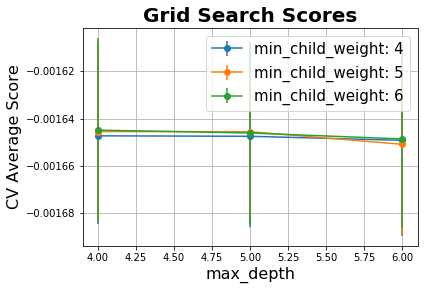

In [19]:
fig, ax = plot_grid_search(gs_results3.cv_results_)

In [20]:
model_concedes4 = XGBClassifier(learning_rate=0.1, n_estimators=100, gamma=0, max_depth=4, min_child_weight=6, 
                                subsample=0.8, colsample_bytree=0.8, scale_pos_weight=1, verbosity=1, seed=42)
params4 = dict(gamma=[0, 0.1, 0.2, 0.3, 0.4, 0.5])
grid_search4 = GridSearchCV(model_concedes4, params4, scoring='brier_score_loss', n_jobs=1, cv=cv, verbose=10,
                            return_train_score=True)
gs_results4 = grid_search4.fit(X_train, y_train)
gs_results4.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] gamma=0 .........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... gamma=0, score=(train=-0.002, test=-0.002), total= 1.8min
[CV] gamma=0 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


[CV] ....... gamma=0, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] gamma=0 .........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s


[CV] ....... gamma=0, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] gamma=0 .........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.7min remaining:    0.0s


[CV] ....... gamma=0, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] gamma=0 .........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.6min remaining:    0.0s


[CV] ....... gamma=0, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] gamma=0.1 .......................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.5min remaining:    0.0s


[CV] ..... gamma=0.1, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] gamma=0.1 .......................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 11.5min remaining:    0.0s


[CV] ..... gamma=0.1, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] gamma=0.1 .......................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 13.4min remaining:    0.0s


[CV] ..... gamma=0.1, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] gamma=0.1 .......................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 15.3min remaining:    0.0s


[CV] ..... gamma=0.1, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] gamma=0.1 .......................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 17.2min remaining:    0.0s


[CV] ..... gamma=0.1, score=(train=-0.002, test=-0.002), total= 1.8min
[CV] gamma=0.2 .......................................................
[CV] ..... gamma=0.2, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] gamma=0.2 .......................................................
[CV] ..... gamma=0.2, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] gamma=0.2 .......................................................
[CV] ..... gamma=0.2, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] gamma=0.2 .......................................................
[CV] ..... gamma=0.2, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] gamma=0.2 .......................................................
[CV] ..... gamma=0.2, score=(train=-0.002, test=-0.002), total= 1.8min
[CV] gamma=0.3 .......................................................
[CV] ..... gamma=0.3, score=(train=-0.002, test=-0.002), total= 1.9min
[CV] gamma=0.3 .......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 57.6min finished


{'gamma': 0.1}

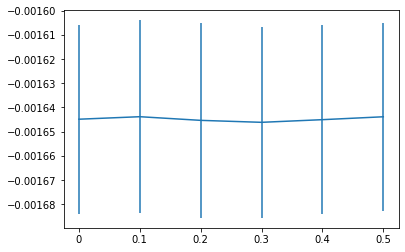

In [21]:
plt.errorbar(range(1, 7),
             gs_results4.cv_results_['mean_test_score'],
             yerr=gs_results4.cv_results_['std_test_score'])
_ = plt.xticks(range(1, 7), [0, 0.1, 0.2, 0.3, 0.4, 0.5])

In [22]:
model_concedes5 = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=4, min_child_weight=6, gamma=0.1,
                                scale_pos_weight=1, verbosity=1, seed=42)
params5 = dict(subsample = [0.4, 0.6, 0.8, 1], colsample_by_tree=[0.4, 0.6, 0.8, 1])
grid_search5 = GridSearchCV(model_concedes5, params5, scoring='brier_score_loss', n_jobs=1, cv=cv, verbose=10,
                            return_train_score=True)
gs_results5 = grid_search5.fit(X_train, y_train)
gs_results5.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] colsample_by_tree=0.4, subsample=0.4 ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_by_tree=0.4, subsample=0.4, score=(train=-0.002, test=-0.002), total= 1.7min
[CV] colsample_by_tree=0.4, subsample=0.4 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV]  colsample_by_tree=0.4, subsample=0.4, score=(train=-0.002, test=-0.002), total= 1.8min
[CV] colsample_by_tree=0.4, subsample=0.4 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.6min remaining:    0.0s


[CV]  colsample_by_tree=0.4, subsample=0.4, score=(train=-0.002, test=-0.002), total= 1.8min
[CV] colsample_by_tree=0.4, subsample=0.4 ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.4min remaining:    0.0s


[CV]  colsample_by_tree=0.4, subsample=0.4, score=(train=-0.002, test=-0.002), total= 1.8min
[CV] colsample_by_tree=0.4, subsample=0.4 ............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.3min remaining:    0.0s


[CV]  colsample_by_tree=0.4, subsample=0.4, score=(train=-0.002, test=-0.002), total= 1.8min
[CV] colsample_by_tree=0.4, subsample=0.6 ............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.1min remaining:    0.0s


[CV]  colsample_by_tree=0.4, subsample=0.6, score=(train=-0.002, test=-0.002), total= 2.1min
[CV] colsample_by_tree=0.4, subsample=0.6 ............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 11.2min remaining:    0.0s


[CV]  colsample_by_tree=0.4, subsample=0.6, score=(train=-0.002, test=-0.002), total= 2.2min
[CV] colsample_by_tree=0.4, subsample=0.6 ............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 13.4min remaining:    0.0s


[CV]  colsample_by_tree=0.4, subsample=0.6, score=(train=-0.002, test=-0.002), total= 2.2min
[CV] colsample_by_tree=0.4, subsample=0.6 ............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 15.7min remaining:    0.0s


[CV]  colsample_by_tree=0.4, subsample=0.6, score=(train=-0.002, test=-0.002), total= 2.1min
[CV] colsample_by_tree=0.4, subsample=0.6 ............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 17.8min remaining:    0.0s


[CV]  colsample_by_tree=0.4, subsample=0.6, score=(train=-0.002, test=-0.002), total= 2.0min
[CV] colsample_by_tree=0.4, subsample=0.8 ............................
[CV]  colsample_by_tree=0.4, subsample=0.8, score=(train=-0.002, test=-0.002), total= 2.2min
[CV] colsample_by_tree=0.4, subsample=0.8 ............................
[CV]  colsample_by_tree=0.4, subsample=0.8, score=(train=-0.002, test=-0.002), total= 2.2min
[CV] colsample_by_tree=0.4, subsample=0.8 ............................
[CV]  colsample_by_tree=0.4, subsample=0.8, score=(train=-0.002, test=-0.002), total= 2.2min
[CV] colsample_by_tree=0.4, subsample=0.8 ............................
[CV]  colsample_by_tree=0.4, subsample=0.8, score=(train=-0.002, test=-0.002), total= 2.2min
[CV] colsample_by_tree=0.4, subsample=0.8 ............................
[CV]  colsample_by_tree=0.4, subsample=0.8, score=(train=-0.002, test=-0.002), total= 2.1min
[CV] colsample_by_tree=0.4, subsample=1 ..............................
[CV]  colsample_

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 167.5min finished


{'colsample_by_tree': 0.4, 'subsample': 1}

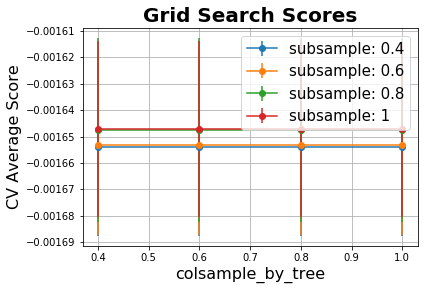

In [37]:
fig, ax = plot_grid_search(gs_results5.cv_results_)

In [23]:
model_concedes6 = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=4, min_child_weight=6, gamma=0.1,
                              subsample=1, colsample_bytree=0.4, scale_pos_weight=1, verbosity=1, seed=42)
params6 = dict(reg_alpha=[0, 1e-2, 1e-1, 1, 10, 1e2], reg_lambda=[0, 1e-2, 1e-1, 1, 10, 1e2])
grid_search6 = GridSearchCV(model_concedes6, params6, scoring='brier_score_loss', n_jobs=1, cv=cv, verbose=10,
                            return_train_score=True)
gs_results6 = grid_search6.fit(X_train, y_train)
gs_results6.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] reg_alpha=0, reg_lambda=0 .......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  reg_alpha=0, reg_lambda=0, score=(train=-0.002, test=-0.002), total= 1.3min
[CV] reg_alpha=0, reg_lambda=0 .......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV]  reg_alpha=0, reg_lambda=0, score=(train=-0.002, test=-0.002), total= 1.3min
[CV] reg_alpha=0, reg_lambda=0 .......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min remaining:    0.0s


[CV]  reg_alpha=0, reg_lambda=0, score=(train=-0.002, test=-0.002), total= 1.3min
[CV] reg_alpha=0, reg_lambda=0 .......................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.0min remaining:    0.0s


[CV]  reg_alpha=0, reg_lambda=0, score=(train=-0.002, test=-0.002), total= 1.3min
[CV] reg_alpha=0, reg_lambda=0 .......................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.4min remaining:    0.0s


[CV]  reg_alpha=0, reg_lambda=0, score=(train=-0.002, test=-0.002), total= 1.2min
[CV] reg_alpha=0, reg_lambda=0.01 ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.6min remaining:    0.0s


[CV]  reg_alpha=0, reg_lambda=0.01, score=(train=-0.002, test=-0.002), total= 1.3min
[CV] reg_alpha=0, reg_lambda=0.01 ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  8.0min remaining:    0.0s


[CV]  reg_alpha=0, reg_lambda=0.01, score=(train=-0.002, test=-0.002), total= 1.3min
[CV] reg_alpha=0, reg_lambda=0.01 ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  9.3min remaining:    0.0s


[CV]  reg_alpha=0, reg_lambda=0.01, score=(train=-0.002, test=-0.002), total= 1.3min
[CV] reg_alpha=0, reg_lambda=0.01 ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 10.7min remaining:    0.0s


[CV]  reg_alpha=0, reg_lambda=0.01, score=(train=-0.002, test=-0.002), total= 1.3min
[CV] reg_alpha=0, reg_lambda=0.01 ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 12.0min remaining:    0.0s


[CV]  reg_alpha=0, reg_lambda=0.01, score=(train=-0.002, test=-0.002), total= 1.2min
[CV] reg_alpha=0, reg_lambda=0.1 .....................................
[CV]  reg_alpha=0, reg_lambda=0.1, score=(train=-0.002, test=-0.002), total= 1.3min
[CV] reg_alpha=0, reg_lambda=0.1 .....................................
[CV]  reg_alpha=0, reg_lambda=0.1, score=(train=-0.002, test=-0.002), total= 1.3min
[CV] reg_alpha=0, reg_lambda=0.1 .....................................
[CV]  reg_alpha=0, reg_lambda=0.1, score=(train=-0.002, test=-0.002), total= 1.3min
[CV] reg_alpha=0, reg_lambda=0.1 .....................................
[CV]  reg_alpha=0, reg_lambda=0.1, score=(train=-0.002, test=-0.002), total= 1.3min
[CV] reg_alpha=0, reg_lambda=0.1 .....................................
[CV]  reg_alpha=0, reg_lambda=0.1, score=(train=-0.002, test=-0.002), total= 1.2min
[CV] reg_alpha=0, reg_lambda=1 .......................................
[CV]  reg_alpha=0, reg_lambda=1, score=(train=-0.002, test=-0.002), t

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 222.3min finished


{'reg_alpha': 0, 'reg_lambda': 0.1}

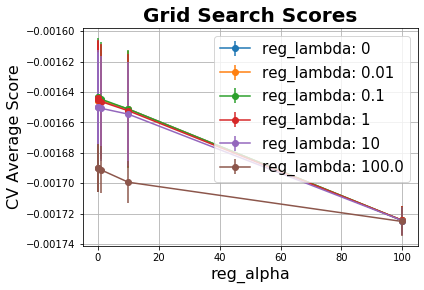

In [24]:
fig, ax = plot_grid_search(gs_results6.cv_results_)

In [25]:
model_concedes7 = XGBClassifier(max_depth=4, min_child_weight=6, gamma=0.1, reg_alpha=0, reg_lambda=0.1, 
                                subsample=1, colsample_bytree=0.4, scale_pos_weight=1, verbosity=1, seed=42)
params7 = dict(learning_rate=[0.01, 0.05, 0.1],
                n_estimators=[100, 500, 1000, 2500])
grid_search7 = GridSearchCV(model_concedes7, params7, scoring='brier_score_loss', n_jobs=1, cv=cv, verbose=10,
                            return_train_score=True)
gs_results7 = grid_search7.fit(X_train, y_train)
gs_results7.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] learning_rate=0.01, n_estimators=100 ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.01, n_estimators=100, score=(train=-0.035, test=-0.035), total= 2.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


[CV] learning_rate=0.01, n_estimators=100 ............................
[CV]  learning_rate=0.01, n_estimators=100, score=(train=-0.035, test=-0.035), total= 2.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.3min remaining:    0.0s


[CV] learning_rate=0.01, n_estimators=100 ............................
[CV]  learning_rate=0.01, n_estimators=100, score=(train=-0.035, test=-0.035), total= 2.1min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.4min remaining:    0.0s


[CV] learning_rate=0.01, n_estimators=100 ............................
[CV]  learning_rate=0.01, n_estimators=100, score=(train=-0.035, test=-0.035), total= 2.1min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  8.5min remaining:    0.0s


[CV] learning_rate=0.01, n_estimators=100 ............................
[CV]  learning_rate=0.01, n_estimators=100, score=(train=-0.035, test=-0.035), total= 1.9min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 10.5min remaining:    0.0s


[CV] learning_rate=0.01, n_estimators=500 ............................
[CV]  learning_rate=0.01, n_estimators=500, score=(train=-0.002, test=-0.002), total= 9.2min
[CV] learning_rate=0.01, n_estimators=500 ............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 19.8min remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=500, score=(train=-0.002, test=-0.002), total= 6.3min
[CV] learning_rate=0.01, n_estimators=500 ............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 26.2min remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=500, score=(train=-0.002, test=-0.002), total= 6.4min
[CV] learning_rate=0.01, n_estimators=500 ............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 32.6min remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=500, score=(train=-0.002, test=-0.002), total= 6.4min
[CV] learning_rate=0.01, n_estimators=500 ............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 39.0min remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=500, score=(train=-0.002, test=-0.002), total= 6.0min
[CV] learning_rate=0.01, n_estimators=1000 ...........................
[CV]  learning_rate=0.01, n_estimators=1000, score=(train=-0.002, test=-0.002), total=12.7min
[CV] learning_rate=0.01, n_estimators=1000 ...........................
[CV]  learning_rate=0.01, n_estimators=1000, score=(train=-0.002, test=-0.002), total=12.6min
[CV] learning_rate=0.01, n_estimators=1000 ...........................
[CV]  learning_rate=0.01, n_estimators=1000, score=(train=-0.002, test=-0.002), total=12.7min
[CV] learning_rate=0.01, n_estimators=1000 ...........................
[CV]  learning_rate=0.01, n_estimators=1000, score=(train=-0.002, test=-0.002), total=12.6min
[CV] learning_rate=0.01, n_estimators=1000 ...........................
[CV]  learning_rate=0.01, n_estimators=1000, score=(train=-0.002, test=-0.002), total=11.9min
[CV] learning_rate=0.01, n_estimators=2500 ...........................
[CV]  learn

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 908.4min finished


{'learning_rate': 0.1, 'n_estimators': 100}

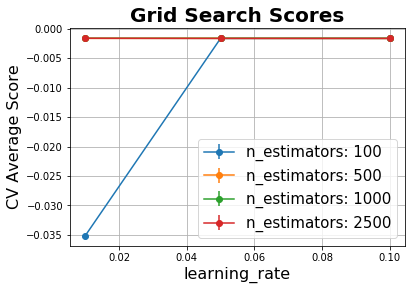

In [28]:
fig, ax = plot_grid_search(gs_results7.cv_results_)

In [21]:
model_concedes_final = XGBClassifier(obj=brier_obj_sklearn,
                                   learning_rate=0.1, n_estimators=100, max_depth=4, min_child_weight=6,
                                   gamma=0.1, reg_lambda=0.1, reg_alpha=0, subsample=1, colsample_bytree=0.4,
                                   scale_pos_weight=1, verbosity=1, seed=42, disable_default_eval_metric=1)
model_concedes_final.fit(X_train, y_train,
                       eval_metric=brier_score_sklearn,
                       eval_set=[(X_train, y_train), (X_test, y_test)],
                       verbose=True,
                       early_stopping_rounds=50)

[0]	validation_0-brier-error:0.20297	validation_1-brier-error:0.20297
Multiple eval metrics have been passed: 'validation_1-brier-error' will be used for early stopping.

Will train until validation_1-brier-error hasn't improved in 50 rounds.
[1]	validation_0-brier-error:0.16515	validation_1-brier-error:0.16515
[2]	validation_0-brier-error:0.13462	validation_1-brier-error:0.13462
[3]	validation_0-brier-error:0.10989	validation_1-brier-error:0.10990
[4]	validation_0-brier-error:0.08984	validation_1-brier-error:0.08985
[5]	validation_0-brier-error:0.07356	validation_1-brier-error:0.07357
[6]	validation_0-brier-error:0.06032	validation_1-brier-error:0.06033
[7]	validation_0-brier-error:0.04954	validation_1-brier-error:0.04955
[8]	validation_0-brier-error:0.04075	validation_1-brier-error:0.04076
[9]	validation_0-brier-error:0.03358	validation_1-brier-error:0.03360
[10]	validation_0-brier-error:0.02774	validation_1-brier-error:0.02776
[11]	validation_0-brier-error:0.02297	validation_1-brier

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4,
              disable_default_eval_metric=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              obj=<function brier_obj_sklearn at 0x7f15ed547b00>,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=0.1, scale_pos_weight=1, seed=42, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=1)

In [22]:
Y_pred['concedes'] = model_concedes_final.predict_proba(X_test)[:, 1]
print(f"  Brier score: %.6f" % brier_score_loss(y_test, Y_pred['concedes']))
print(f"  ROC AUC: %.4f" % roc_auc_score(y_test, Y_pred['concedes']))

  Brier score: 0.001637
  ROC AUC: 0.8565


/home/kuba/anaconda3/envs/the-value-of-line-breaking-pass/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


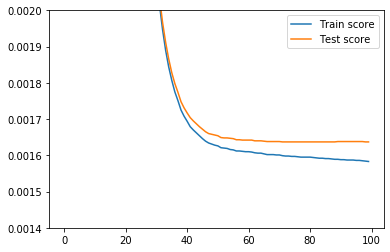

In [23]:
results = model_concedes_final.evals_result()
epochs = len(results['validation_0']['brier-error'])
fig, ax = plt.subplots()
ax.plot(range(0, epochs), results['validation_0']['brier-error'], label='Train score')
ax.plot(range(0, epochs), results['validation_1']['brier-error'], label='Test score')
ax.set_ylim(0.0014, 0.0020)
ax.legend()
fig.show()

In [25]:
pickle.dump(model_concedes_final, open('model_concedes.pkl', 'wb'))